In [14]:
import os
import gc
import copy
import time
import datetime
import argparse
import ast
from tqdm import tqdm
import random
from joblib import Parallel, delayed
from argparse import Namespace
from itertools import product
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from umap import UMAP

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [13]:
##########################
### Load mesh information
##########################
disease_mesh_df = pd.read_csv("../data/fig2-3/MeSH/mesh_disease_leaves_w_annotation.csv")
disease_mesh_df["tree_categories"] = disease_mesh_df["tree_categories"].apply(ast.literal_eval)
display(disease_mesh_df.head())
display(disease_mesh_df.shape)

mesh_category_name_df = pd.read_csv("../data/fig2-3/MeSH/MeSH_large_categories.csv")
display(mesh_category_name_df.head())
display(mesh_category_name_df.shape)

mesh2disease = dict(zip(disease_mesh_df["mesh_id"], disease_mesh_df["label"]))
mesh2category = dict(zip(disease_mesh_df["mesh_id"], disease_mesh_df["first_tree_category"]))
disease2mesh = dict(zip(disease_mesh_df["label"], disease_mesh_df["mesh_id"]))
category2name = dict(zip(mesh_category_name_df["mesh_id"], mesh_category_name_df["name"]))

,mesh_id,label,tree_numbers,tree_categories,n_articles,annotation,scope_note,chunk_number,sorted_tree_categories,first_tree_category
0,D000785,"Aneurysm, Infected","['C01.069', 'C14.907.055.131']","[C01, C14]",8740,coordinate IM with specific bacteria or fungal...,Aneurysm due to growth of microorganisms in th...,1,"['C14', 'C01']",C14
1,D016918,"Arthritis, Reactive","['C01.100.500', 'C05.116.900.853.625.800.637',...","[C01, C05, C23]",11631,coordinate with specific infection or organism...,"An aseptic, inflammatory arthritis developing ...",1,"['C05', 'C23', 'C01']",C05
2,D058345,Asymptomatic Infections,"['C01.125', 'C23.550.291.187.500']","[C01, C23]",7281,NaN,Infections that do not exhibit symptoms.,1,"['C01', 'C23']",C01
3,D006483,Hemorrhagic Septicemia,"['C01.150.252.100.375', 'C01.150.252.400.700.6...","[C01, C23]",1207,coord (IM) withPASTEURELLA MULTOCIDA(IM) or sp...,"Any of several bacterial diseases, usually cau...",1,"['C23', 'C01']",C23
4,D020852,Lyme Neuroborreliosis,"['C01.150.252.223.437', 'C01.150.252.400.536.7...","[C01, C10]",3136,coord IM with Borrelia (IM) + specific site/di...,Nervous system infections caused by tick-borne...,1,"['C10', 'C01']",C10


(2941, 10)

,mesh_id,name
0,C01,Infections
1,C04,Neoplasms
2,C05,Musculoskeletal Diseases
3,C06,Digestive System Diseases
4,C07,Stomatognathic Diseases


(23, 2)

In [4]:
###########################
### Load static GRNs
###########################
# Load gene-gene interactions from BioREX database
relations_df = pd.read_csv("../data/fig2-3/all_human_gene_interactions_2024-12-18.csv")
all_pairs = np.array(sorted(list(set(relations_df.apply(lambda x: "--".join(sorted([x["from_gene"], x["to_gene"]])), axis=1)))))
display(relations_df.head())
display(relations_df.shape)

,pmid,relation,from,to,to_isgene,from_isgene,from_gene,to_gene,from_organism,to_organism,from_entrez,to_entrez,is_directed,year
0,33846805,associate,Gene|5289,Gene|5562,True,True,PIK3C3,PRKAA1,human,human,5289,5562,False,2021.0
1,33846805,associate,Gene|5289,Gene|8408,True,True,PIK3C3,ULK1,human,human,5289,8408,False,2021.0
2,33846805,associate,Gene|7157,Gene|5366,True,True,TP53,PMAIP1,human,human,7157,5366,True,2021.0
3,33846805,associate,Gene|5562,Gene|8408,True,True,PRKAA1,ULK1,human,human,5562,8408,True,2021.0
4,33846805,associate,Gene|2475,Gene|5289,True,True,MTOR,PIK3C3,human,human,2475,5289,False,2021.0


(3017208, 14)

In [11]:
###########################
### Load context-dependent GRNs
###########################
relation_corr_df = pd.concat([
    pd.read_parquet("../data/fig2-3/All_MeSH_diseases_log1p_CPM_chunk1.parquet").iloc[:, 1:],
    pd.read_parquet("../data/fig2-3/All_MeSH_diseases_log1p_CPM_chunk2.parquet").iloc[:, 1:],
    pd.read_parquet("../data/fig2-3/All_MeSH_diseases_log1p_CPM_chunk3.parquet").iloc[:, 1:]
], axis=1)

# Drop relations that are not detected in any of the diseases
is_drop = np.array((relation_corr_df == 0).all(axis=1))
print("Number of relations to drop:", is_drop.sum())
all_pairs = all_pairs[~is_drop]

relation_corr_df = relation_corr_df[~is_drop].reset_index(drop=True)

display(relation_corr_df.head())
display(relation_corr_df.shape)

# Calculate the sparsity
sparsity = (relation_corr_df.values == 0).mean()
print(f"Averaged sparsity of the context-dependent GRN: {sparsity:.2%}")

Number of relations to drop: 11134


,D000785,D016918,D058345,D006483,D020852,D008583,D008584,D014884,D008586,D014390,...,D000083102,D000070636,D012652,D000069836,D000072836,D005409,D055370,D020221,D014948,D016602
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(880469, 2941)

Averaged sparsity of the context-dependent GRN: 87.99%


In [12]:
############################
### Dimension reduction
############################
scaler = StandardScaler()
pca = PCA(n_components=200, random_state=42)

scaled_corr = scaler.fit_transform(relation_corr_df.values.T)
pca_feat = pca.fit_transform(scaled_corr)
umap_mapper = UMAP(n_components=2, random_state=42)
umap_coord = umap_mapper.fit_transform(pca_feat)

/home/masato-tsutsui/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/masato-tsutsui/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/masato-tsutsui/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/masato-tsutsui/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/masato-tsutsui/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on

StratifiedKFold Accuracy: 0.7355 ± 0.0149


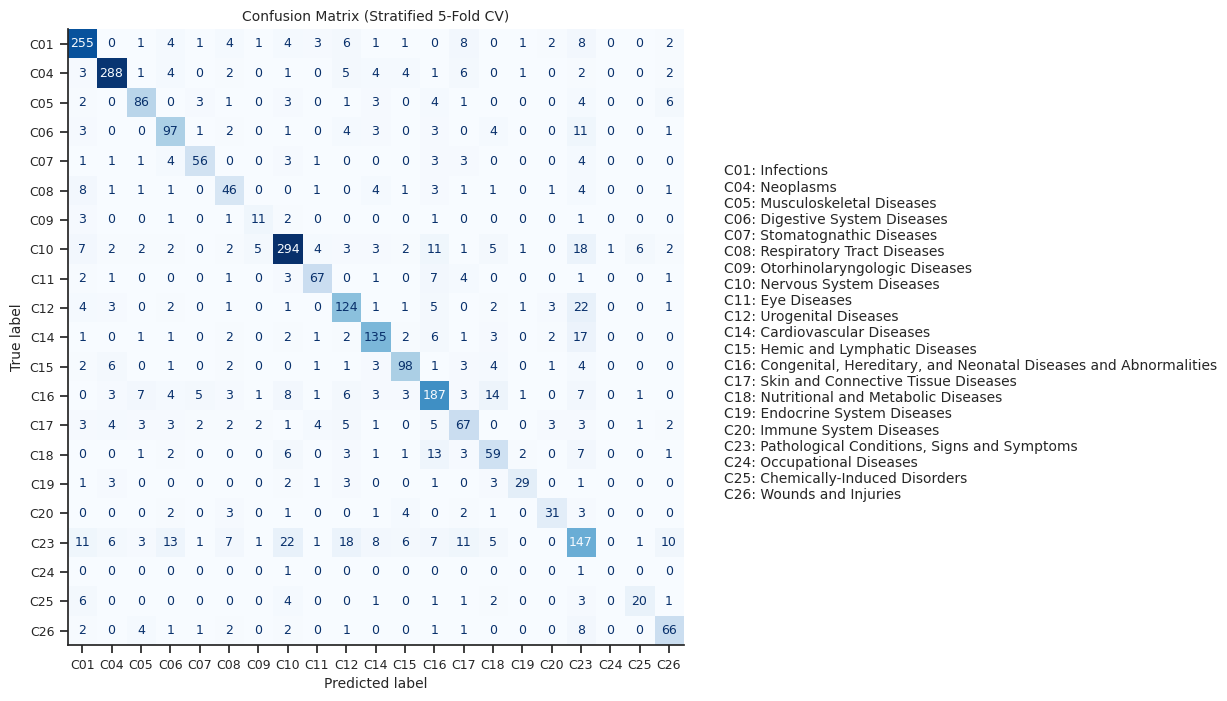

In [15]:
#############################
### Evaluate whether the PCA features can distinguish disease categories
#############################
# Logistic regression and Stratified K-Fold
clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For storing accuracies and confusion matrix
fold_accuracies = []
y_true_all = []
y_pred_all = []

# Cross-validation
labels = np.frompyfunc(lambda x: mesh2category[x], 1, 1)(relation_corr_df.columns)
for train_index, test_index in skf.split(pca_feat, labels):
    X_train, X_test = pca_feat[train_index], pca_feat[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Calculate mean and std of accuracies
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"StratifiedKFold Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

# Confusion matrix
unique_labels = np.unique(labels)
unique_disp_labels = np.frompyfunc(lambda x: category2name[x], 1, 1)(unique_labels)
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))

fig, ax = plt.subplots(figsize=(9,8))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
for text in ax.texts:
    text.set_fontsize(9)
ax.set_title("Confusion Matrix (Stratified 5-Fold CV)", fontsize=10)

ax.set_xlabel("Predicted label", fontsize=10)
ax.set_ylabel("True label", fontsize=10)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

mapping_text = "\n".join(f"{s}: {l}" for s, l in zip(unique_labels, unique_disp_labels))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
fig.text(0.9, 0.5, mapping_text, va='center', fontsize=10, bbox=props)
plt.savefig("../data/fig2-3/fig3.confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

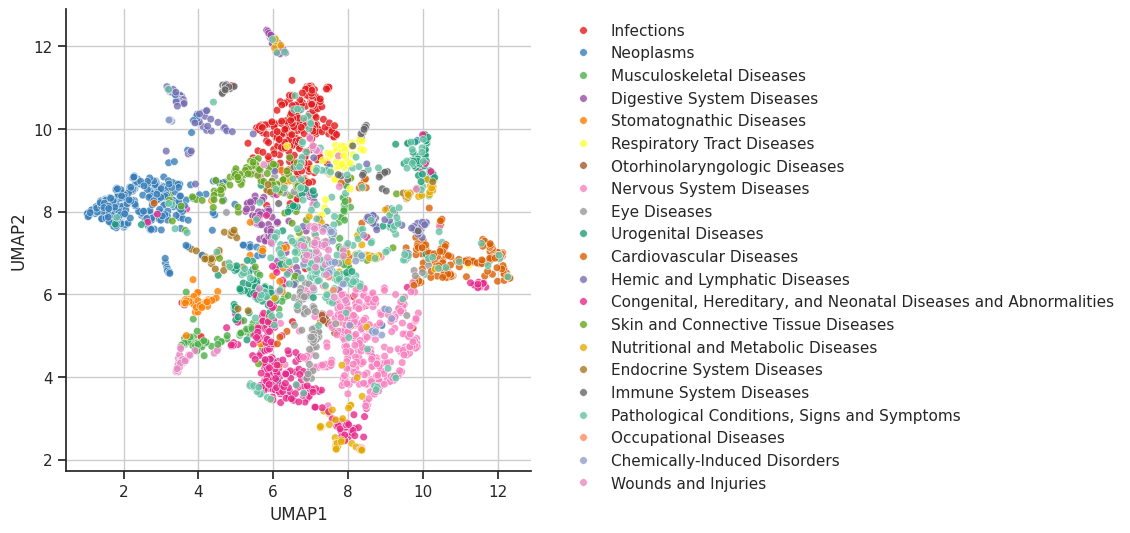

In [16]:
###########################
### Network visualization
###########################
custom_palette = sns.color_palette("Set1") + sns.color_palette("Dark2") + sns.color_palette("Set2")[:4]

fig, ax = plt.subplots(figsize=(6, 6))

tree_categories = np.frompyfunc(lambda x: category2name[x], 1, 1)(disease_mesh_df["first_tree_category"])
hue_order = [category2name[x] for x in sorted(list(set(disease_mesh_df["first_tree_category"])))]

sns.scatterplot(x=umap_coord[:, 0], y=umap_coord[:, 1], ax=ax, palette=custom_palette,
                hue=tree_categories, hue_order=hue_order, s=30, alpha=0.8)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.grid(True)
plt.show()

fig.savefig("../data/fig2-3/fig3.context-dependent_GRNs_UMAP.png", bbox_inches="tight", dpi=300)

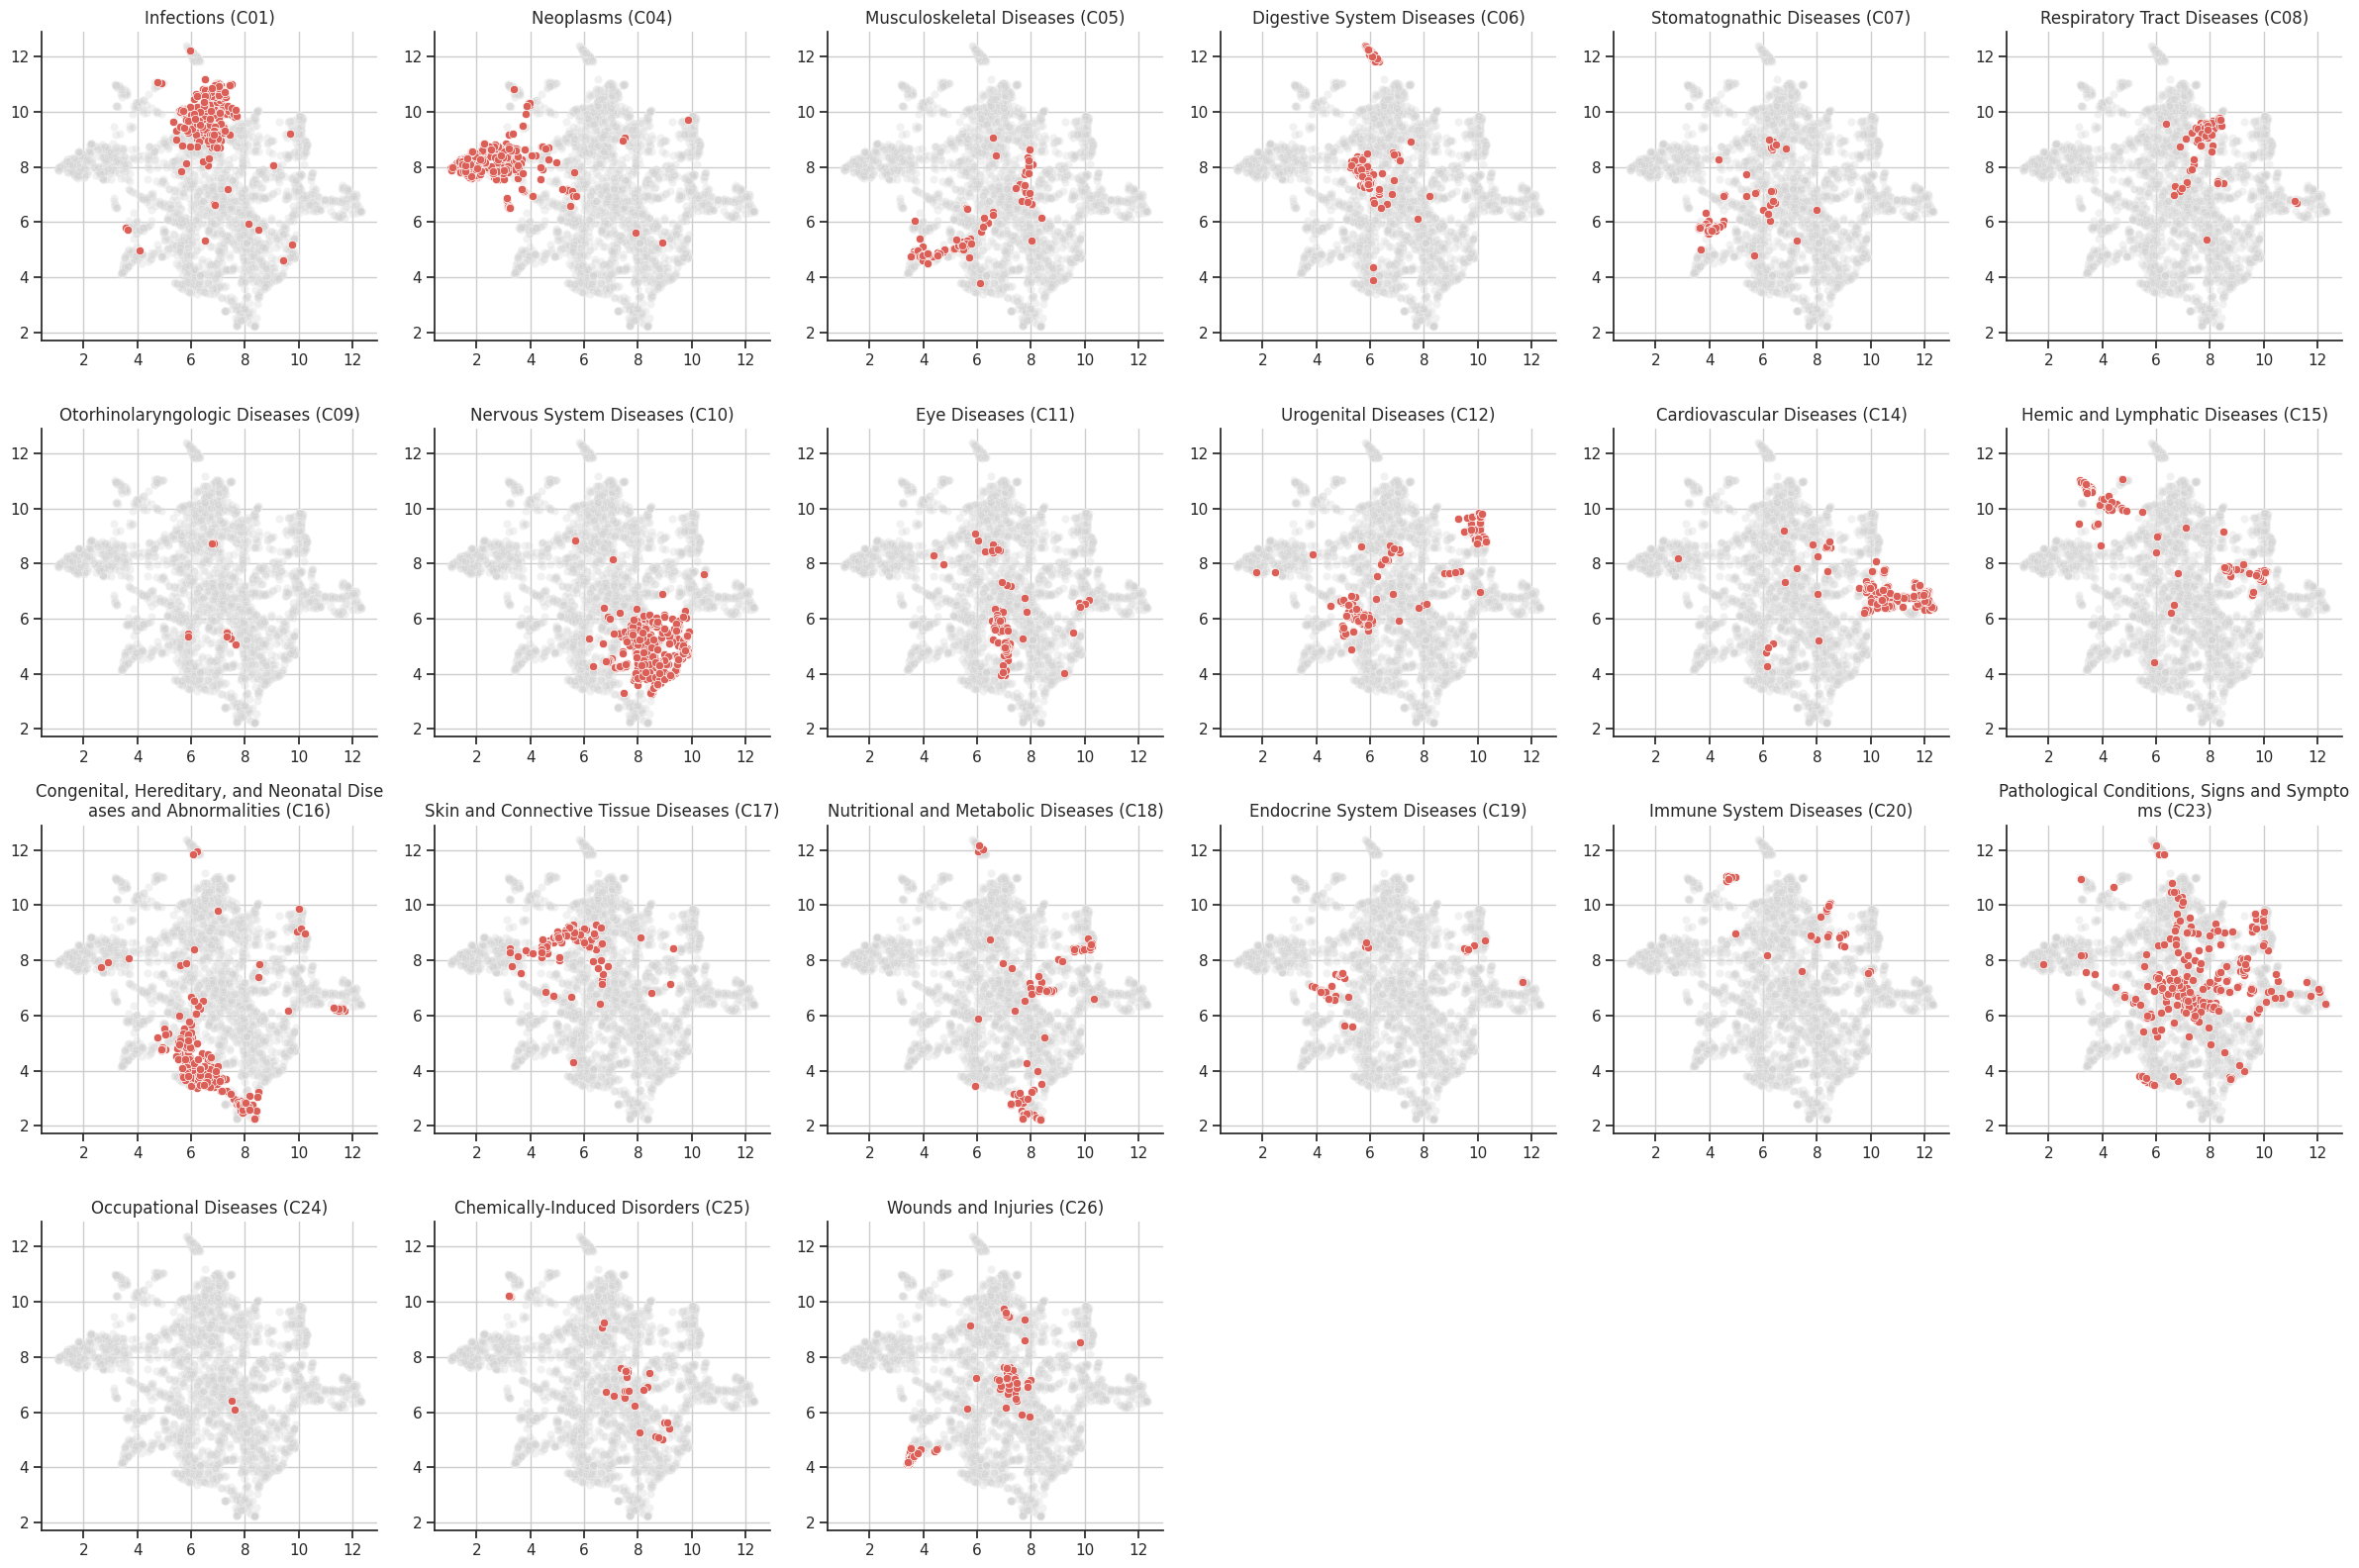

In [20]:
ncols, nrows = 6, 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(24, 16))
axes = axes.flatten()

for i, category in enumerate(sorted(list(set(disease_mesh_df["first_tree_category"])))):
    category_name = category2name[category]
    
    mask = np.where(disease_mesh_df["first_tree_category"].apply(lambda x: category in x))[0]
    mask_color = sns.color_palette("hls")[0]

    sns.scatterplot(x=umap_coord[:, 0], y=umap_coord[:, 1], color="lightgrey", alpha=0.3, ax=axes[i])
    sns.scatterplot(x=umap_coord[mask, 0], y=umap_coord[mask, 1], color=mask_color, ax=axes[i])
    
    title_text = f"{category_name} ({category})"
    if len(title_text) > 41:
        title_text = title_text[:41] + "\n" + title_text[41:]
    axes[i].set_title(title_text)
    axes[i].grid(True)

for i in range(ncols * nrows):
    if i >= len(set(disease_mesh_df["first_tree_category"])):
        axes[i].axis('off')

fig.tight_layout()
plt.show()